In [1]:
import pandas as pd
import numpy as np
import os
import fnmatch
from scipy import stats
import matplotlib.pyplot as plt
import re

In [2]:
# Process human recorded responses
# This assumes the table format shown in FORMAT.xlsx (but may have RET instead of REC)
# Order of the phases in the first column is not important but within each phase, the intervals must be ordered and all CSp but be before all CSm (as shown in the FORMAT.xlxs)
# The column headings must be as specified in FORMAT.xlxs

def process_human(df, phases):
    df = df.replace(-99, np.nan).apply(pd.to_numeric, errors="coerce").fillna(0)
    data = []
    for phase in phases:
        if phase == "US":
            data.extend(df[df.index.str.match('US')][['Full_SCR']].transpose().values.flatten())
        else:
            data.extend(df[df.index.str.match(phase)][['Full_SCR', 'FIR_SCR', 'SIR_SCR', 'TIR_SCR']].transpose().values.flatten())

    return np.array(data)

In [3]:
# Process csv output by the algorithm
# Assumes that within each phase the intervals are ordered and that the csv contains all intervals that exist in the human recorded response files (i.e. if ACQ phase in human recorded response file has 8 intervals, assumes all 8 intervals exist within the csv)
def process_algorithm(df, row, phases):
    df = df.fillna(0)
    data = []
    cols = []
    for phase in phases:
        if phase != "US":
            data.extend(df.loc[row, df.columns[df.columns.str.match(phase+'.*SCR')]].to_numpy())
            cols.extend(df.columns[df.columns.str.match(phase+'.*SCR')])

    return {'data': np.array(data), 'cols': cols}

In [4]:
# Process csv output by the algorithm when gsr data split across two files (two csvs produced - one with PREACQ, ACQ and EXT, and the other with REC phase)
# Assumes that within each phase the intervals are ordered and that the csv contains all intervals that exist in the human recorded response files (i.e. if ACQ phase in human recorded response file has 8 intervals, assumes all 8 intervals exist within the csv)
def process_algorithm_multiple(df, df_rec, row, phases):
    df = df.fillna(0)
    df_rec = df_rec.fillna(0)
    data = []
    cols = []
    for phase in phases:
        if phase != "US" and phase != "REC":
            data.extend(df.loc[row, df.columns[df.columns.str.match(phase+'.*SCR')]].to_numpy())
            cols.extend(df.columns[df.columns.str.match(phase+'.*SCR')])
        elif phase == "REC":
            data.extend(df_rec.loc[row, df_rec.columns[df_rec.columns.str.match('REC.*SCR')]].to_numpy())
            cols.extend(df_rec.columns[df_rec.columns.str.match('REC.*SCR')])
    return {'data': np.array(data), 'cols': cols}

In [5]:
# Creates a dataframe of the differences between the human recorded responses and the output of the algorithm
# Algorithm is a dataframe that can contain RET, PREACQ, ACQ and EXT phases (i.e. gsr data all in one file so only one csv produced)
# Algorithm_rec is a dataframe that contains the REC phase (only used when gsr data split across two files)
# Phases can be RET, PREACQ, ACQ, US, EXT, REC
def create_comparison(algorithm, algorithm_rec, human_dir, phases):
    # Get files containing human analysis
    file_numbers = algorithm.index
    files = os.listdir(human_dir)

    # List to store data to produce dataframe of differences
    data = []
    index = []

    # List to store df to locate differences larger than threshold
    dfs = []

    # Iterate over each row in algorithm output
    for num in file_numbers:
        for file in files:
            # Find corresponding human analysis file
            if fnmatch.fnmatch(file, '*' + str(num) + '*.xlsx'):
                # Process the human analysis file and algorithm analysis row
                human_raw = pd.read_excel(human_dir+'/'+file, index_col=0)
                human_processed = process_human(human_raw, phases)
                if algorithm_rec is None:
                    algorithm_processed = process_algorithm(algorithm, num, phases)
                else:
                    algorithm_processed = process_algorithm_multiple(algorithm, algorithm_rec, num, phases)
                # Calculate the difference and add to data
                diff = algorithm_processed['data'] - human_processed
                data.append(diff)
                index.append(num)

                # Create df containing human and algorithm values 
                df = pd.DataFrame([algorithm_processed['data'], human_processed], index=['Algorithm', 'Human'], columns=algorithm_processed['cols'])
                df.index.name = num
                dfs.append(df)

    return {'diff':pd.DataFrame.from_records(data, columns=algorithm_processed['cols'], index=index), 'dfs':dfs}

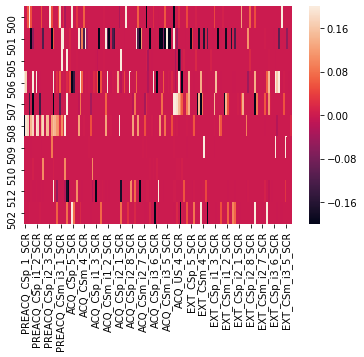

In [31]:
algorithm = pd.read_csv("C:/Users/mq30513723/Documents/Experiment Data/analysis files/output/fc/output_0_25.csv", index_col=0)
# algorithm_rec = pd.read_csv("Z:/analysis files/output/fc_b/output_0_15.csv", index_col=0)
human_dir = 'C:/Users/mq30513723/Documents/Experiment Data/analysis files/hand coded results/FC'
comparison = create_comparison(algorithm, None, human_dir, ['PREACQ', 'ACQ', 'US', 'EXT'])

import seaborn as sns
sns.set_palette("Spectral", 10) #why won't this work???
sns.heatmap(comparison["diff"].replace(-99,0).replace(99,0).clip(-0.2,0.2))


In [7]:
# Create excel files that show phases where the difference between human and algorithm are greater than the given threshold 
# Idea is that Carly then puts an 'X' or 'Y' in a third row to indicate which value is correct
def create_excel_differences(dfs, threshold):
    for df in dfs:
        cols = df.columns[(abs(df.loc['Human'] - df.loc['Algorithm']) > threshold)]
        name = df.index.name
        # Rename rows to X and Y to avoid bias
        #df.rename(index={'Human':'X', 'Algorithm':'Y'}, inplace=True) 
        df[cols].to_csv('C:/Users/mq30513723/Documents/Experiment Data/analysis files/file_diff/difference'+str(name)+'.csv')

create_excel_differences(comparison['dfs'], 0.02)

In [8]:
# Read in the difference files and calculate the total number of 'X' and 'Y' which correspond to Human and Algorithm respectively 
# Determine how many times the algorithm was correct and how many times the human was correct
diff_dir = 'C:/Users/mq30513723/Documents/Experiment Data/analysis files/file_diff'
def process_diff_files(diff_dir):
    files = os.listdir(diff_dir)
    human = 0
    algorithm = 0
    for file in files:
        df = pd.read_csv(diff_dir + '/' + file, index_col=0)
        human += sum(df.iloc[2] == 'H')
        algorithm += sum(df.iloc[2] == 'A')
    return {'Human correct':human, 'Algorithm correct':algorithm}

process_diff_files(diff_dir)

IndexError: single positional indexer is out-of-bounds

In [ ]:
# Extract full and third interval for analysis (independent)
def extract_test_data(df):
    result = df[df.columns[df.columns.str.match('(.*(CSp|CSm)_\d{1}_SCR)|(.*US_\d{1}_SCR)|(.*(CSp|CSm)_i3_\d{1}_SCR)')]]
    return result

In [ ]:
data = extract_test_data(comparison['diff']).values.flatten()
# Look at scatter plot to identify any large outliers
plt.scatter(data, range(len(data)))
plt.show()
# Mistake in human data - forget decimal point so appeared as -23000 and -30000
data = data[abs(data) < 1000]

# Perform wilcoxon test to determine if differences significantly different from 0
stat, pval = stats.wilcoxon(data)
if pval < 0.05:
    print('Differences signigicantly different from 0')
else:
    print('No significant differences between human and algorithm')

In [ ]:
# Determines number of differences that have an absolute value above the threshold 
# Produces df that has three columns; Positive for differences > threshold, Negative for differences < -threshold and No Difference for differences >= -threshold and <=threshold
# Note differences are calculated as algorithm - human
def count_diff_file(difference, threshold): 
    file_pos = (difference > threshold).sum(axis=1) / difference.shape[1] * 100
    file_neg = (difference < -threshold).sum(axis=1) / difference.shape[1] * 100
    file_zero = (difference.shape[1] - file_neg - file_pos) / difference.shape[1] * 100
    file_df = pd.DataFrame({'Positive':file_pos, 'Negative':file_neg, 'No Difference ':file_zero})
    return file_df.round(2)

count_diff_file(comparison['diff'], 0.02).plot.bar()
count_diff_file(comparison['diff'], 0.02)

In [ ]:
def count_diff_total(difference, threshold): 
    total = difference.shape[0] * difference.shape[1]
    pos = (difference > threshold).sum().sum() / total * 100
    neg = (difference < -threshold).sum().sum() / total * 100
    zero = (total - neg - pos) / total * 100
    df = pd.DataFrame({'Positive':[pos], 'Negative':[neg], 'No Difference ':[zero]}, index=['Total'])
    return df.round(2)

count_diff_total(comparison['diff'], 0.02).plot.bar()
count_diff_total(comparison['diff'], 0.02)